- O(입력/출력) 비용을 줄이기 위해 인덱스 전용 스캔(인덱스 전용 액세스라고도 함)은 SELECT 문의 대상 항목이 모두 포함된 경우 해당 테이블 페이지에 액세스하지 않고 인덱스 키를 직접 사용.
- 이 기술은 DB2 및 Oracle과 같은 거의 모든 상용 RDBMS에서 제공.
- PostgreSQL은 버전 9.2부터 이 옵션을 도입.

- 다음에서는 특정 예를 사용하여 PostgreSQL에서 인덱스 전용 스캔이 수행되는 방식에 대한 설명이 제공.

- 예제의 가정은 아래에 설명

**테이블 정의**
- 아래에 정의가 표시된 'tbl' 테이블이 있음.


```
testdb=# \d tbl
      Table "public.tbl"
 Column |  Type   | Modifiers
--------+---------+-----------
 id     | integer |
 name   | text    |
 data   | text    |
Indexes:
    "tbl_idx" btree (id, name)
```

**인덱스**

- 'tbl' 테이블에는 'id'와 'name'이라는 두 개의 열로 구성된 'tbl_idx' 인덱스가 있음.

**튜플**

- 'tbl'이 이미 튜플을 삽입했음.
  - 0번째 페이지에는 ID가 18, 이름이 'Queen'인 Tuple_18이 저장되어 있음.
  - 첫 번째 페이지에는 ID가 19이고 이름이 'BOSTON'인 Tuple_19가 저장되어 있

**가시성**

- 0번째 페이지의 모든 튜플은 항상 표시됨.
- 첫 번째 페이지의 튜플이 항상 표시되는 것은 아님.
- 각 페이지의 가시성은 해당 VM(Visibility Map)에 저장

**다음 SELECT 명령이 실행될 때 PostgreSQL이 튜플을 읽는 방법**

```
testdb=# SELECT id, name FROM tbl WHERE id BETWEEN 18 and 19;
 id |  name   
----+--------
 18 | Queen
 19 | Boston
(2 rows)
```

- 이 쿼리는 테이블의 두 컬럼 'id'와 'name'에서 데이터를 가져오며, 이 컬럼들로 인덱스 'tbl_idx'가 구성.
  - 따라서 인덱스 튜플에 필요한 데이터가 포함되어 있으므로 인덱스 스캔을 사용할 때 테이블 페이지에 액세스할 필요가 없는 것처럼 보임.

- 그러나 실제로 PostgreSQL은 원칙적으로 튜플의 가시성을 확인해야 함.
  - 인덱스 튜플에는 힙 튜플의 t_xmin 및 t_xmax와 같은 트랜잭션에 대한 정보가 없음.

- 따라서 PostgreSQL은 인덱스 튜플에 있는 데이터의 가시성을 확인하기 위해 테이블 ​​데이터에 액세스해야 함.
  - 이는 말 앞에 수레를 놓는 것과 같음.

- 이러한 딜레마를 피하기 위해 PostgreSQL은 대상 테이블의 가시성 맵을 사용.
  - 페이지에 저장된 모든 튜플이 표시되면 PostgreSQL은 인덱스 튜플의 키를 사용하고 가시성을 확인하기 위해 인덱스 튜플에서 가리키는 테이블 페이지에 액세스하지 않음.
  - 그렇지 않으면 PostgreSQL은 인덱스 튜플에서 가리키는 테이블 튜플을 읽고 튜플의 가시성을 확인하는 일반적인 프로세스.

- 이 예에서는 Tuple_18을 저장하는 0번째 페이지가 표시되므로 Tuple_18에 액세스할 필요가 없음.
  - 즉, Tuple_18을 포함하여 0번째 페이지의 모든 튜플이 표시됨.
  - 반면 Tuple_19는 첫 번째 페이지의 가시성이 보이지 않기 때문에 동시성 제어를 처리하기 위해 액세스해야 함

**How Index-Only Scans performs**

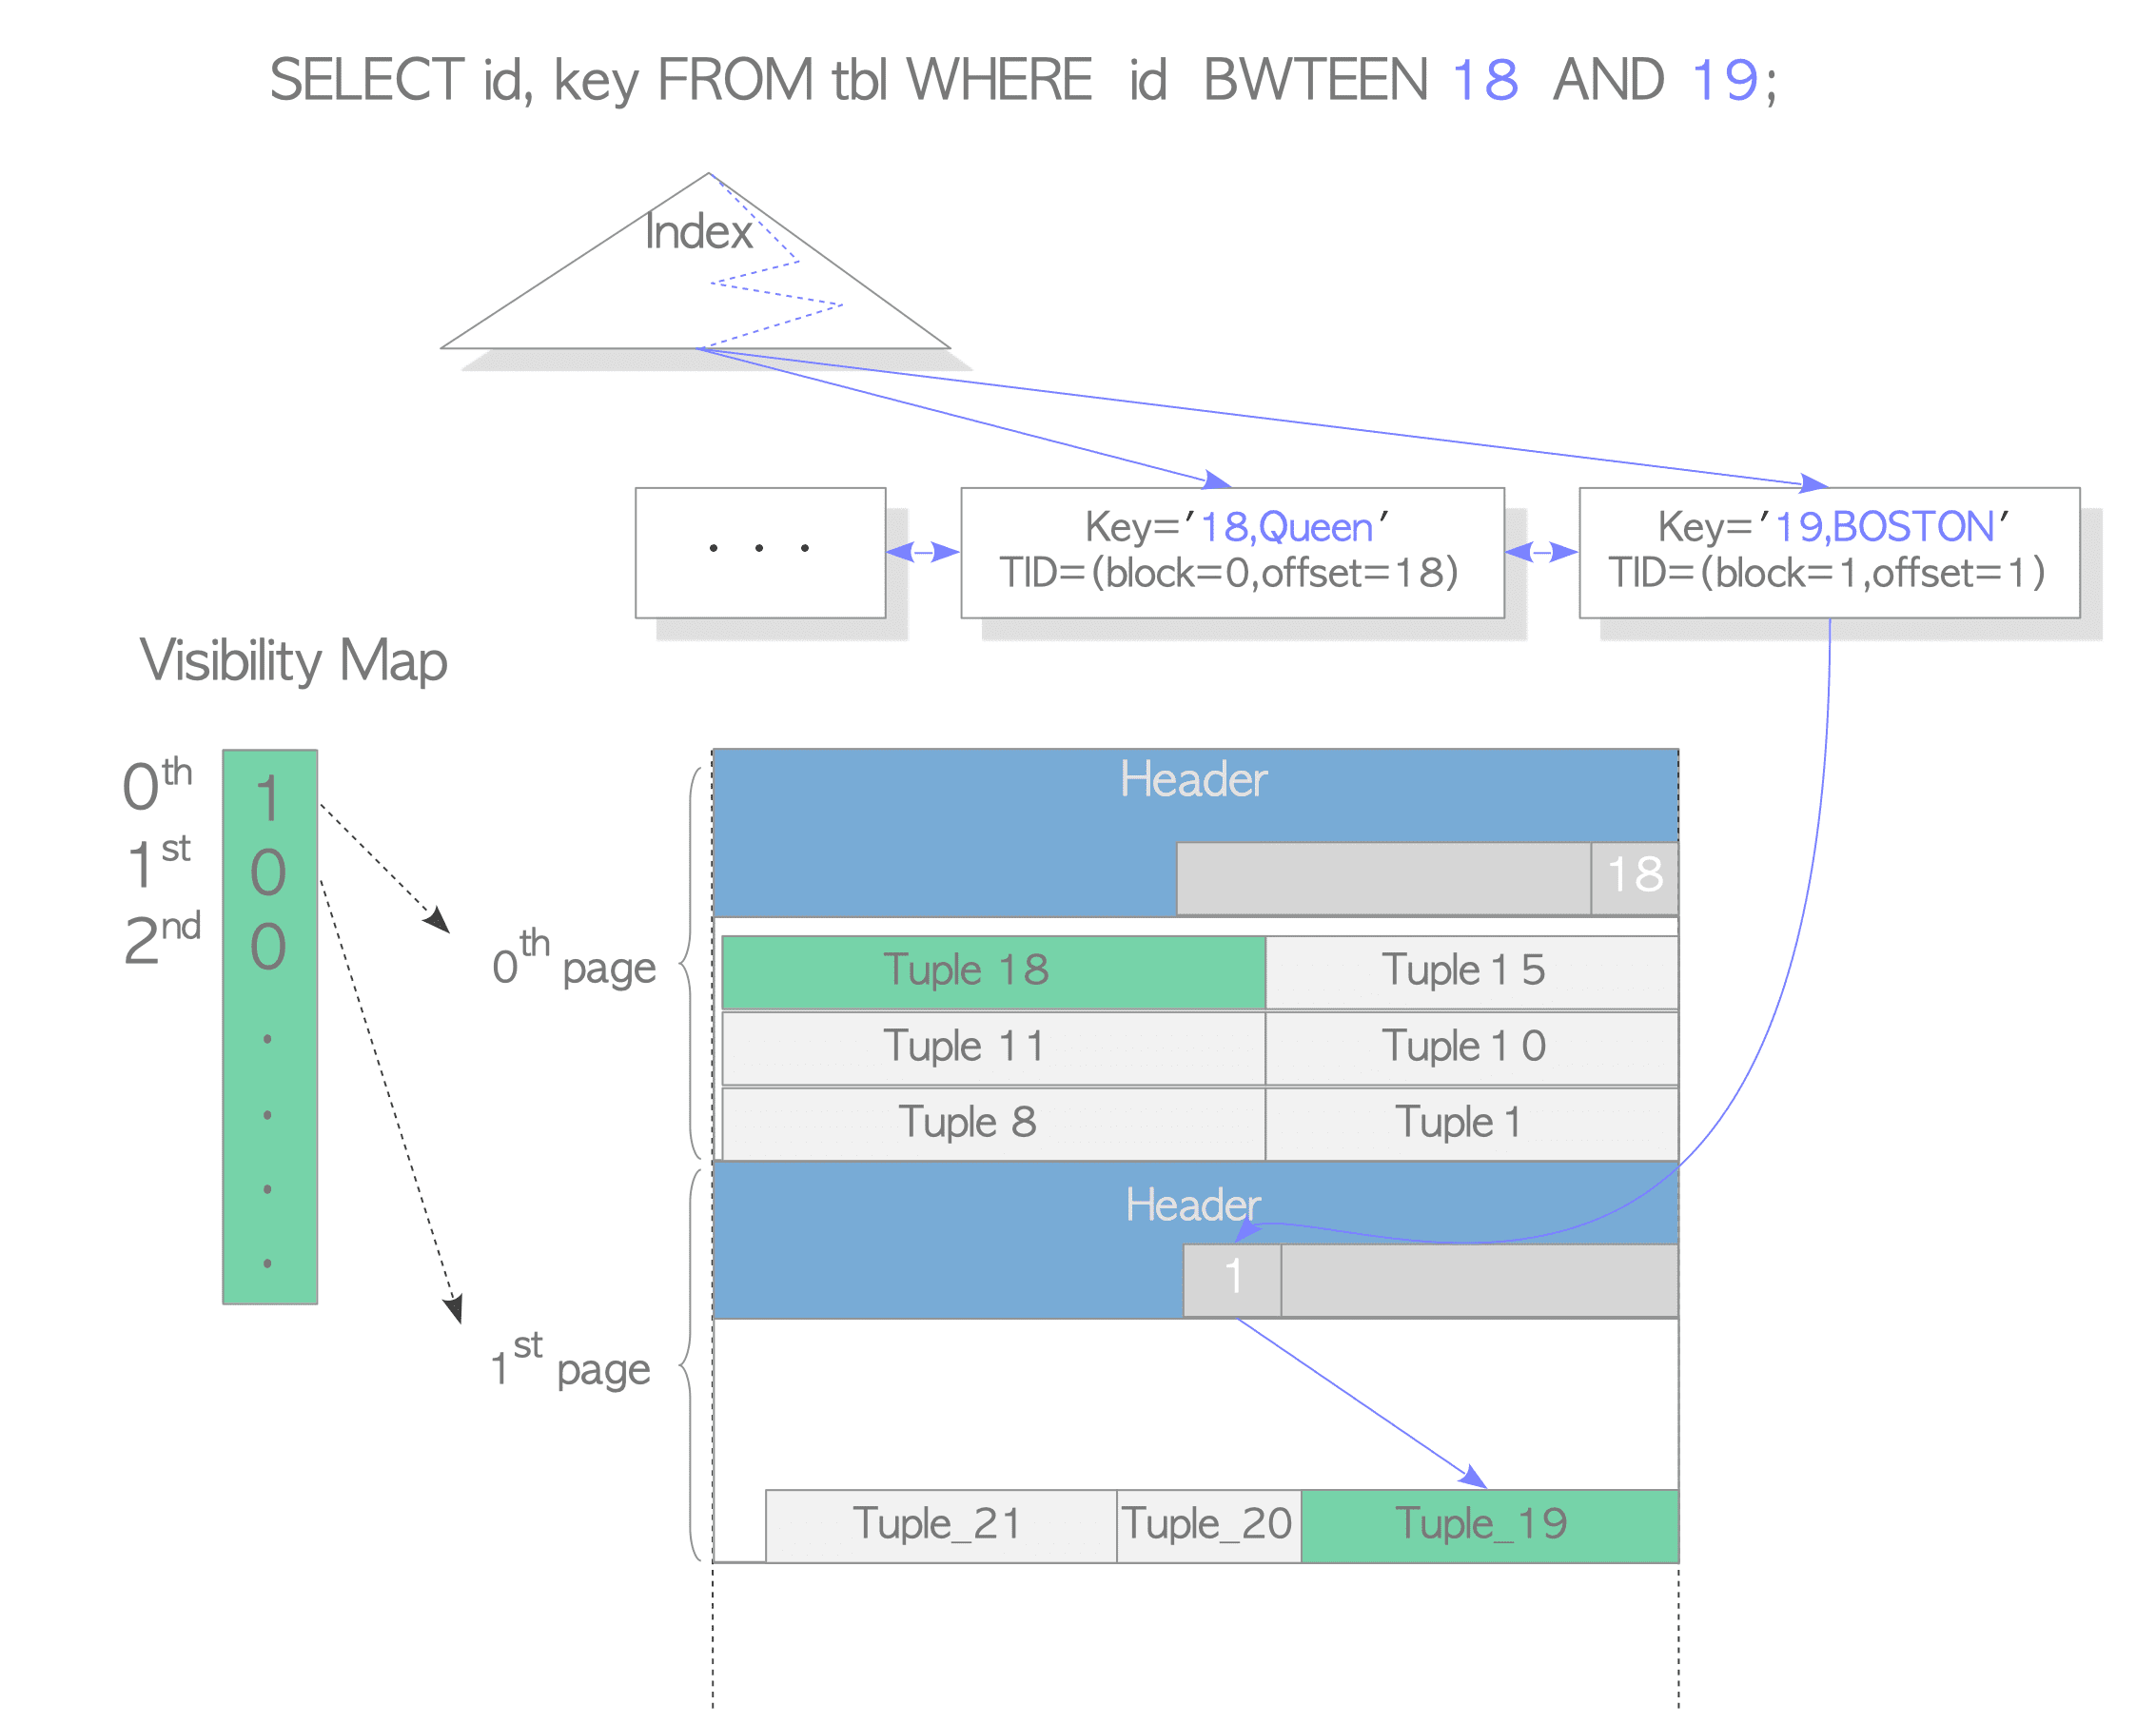